In [1]:
'''
as part of MS4 green infrastructure equity work and following this guidance from MA: 
https://www.mass.gov/doc/2016-massachusetts-small-ms4-permit-pollutant-loading-export-rates/download

generating PLER values for each land cover area in each municipality

created: 5/2/2023
author: rbowers

'''

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("..")
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from rasterstats import zonal_stats
import contextily as cx
#import osmnx as ox
from affine import Affine
import rioxarray as rx
from multiprocessing import Pool, cpu_count
from shapely.ops import unary_union
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr 
from numpy import int16
from shapely.geometry import mapping
import pysheds
from pysheds.grid import Grid
from shapely.validation import make_valid



#see all columns in tables
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [63]:
from src.features.build_features import *

In [3]:
muni = 'Natick'

print('Starting on municipality: ', muni)

#read in municipalities, select the one of interest
#municipalities
munis_fp = "K:\\\DataServices\\Datasets\\Boundaries\\Spatial\\mapc_towns_poly.shp"
munis = gpd.read_file(munis_fp)


print('Reading in urban heat island Data...')
#bring in heat island raster so that we can build our dataset off of it 
heat_fp = 'K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_Heat_MVP\\00 Task 2 Deliverables\\2.1 Attachments\\00 Uploaded to Sharepoint\\Shapefile_LSTIndex\\LSTindex.tif'

#masking raster by muni
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
heat = rxr.open_rasterio(heat_fp,masked=True).squeeze()
heat_muni = heat.rio.clip(muni_shp.geometry.apply(mapping),muni_shp.crs)



Starting on municipality:  Natick
Reading in Land Cover/Land Use Data...
Reading in Soils Data...
Reading in urban heat island Data...


In [9]:
munis_list = ['Franklin', 'Norwood', 'Reading', 'Winchester', 'Natick']


for muni in munis_list:

    #read in municipalities, select the one of interest
    #municipalities
    munis_fp = "K:\\\DataServices\\Datasets\\Boundaries\\Spatial\\mapc_towns_poly.shp"
    ms4_gdb = 'K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Project\\MS4_Tool_Preprocessing.gdb'
    ms4_model_gdb = 'K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Project\\MS4_Model.gdb'


    munis = gpd.read_file(munis_fp)

    #select just the muni 
    muni_shp = munis.loc[munis['municipal'] == muni]


    print('Reading in Land Cover/Land Use Data for ' + muni + '...') 

    #land use geodatabase location
    #lclu_gdb = "K:\\DataServices\\Datasets\\Zoning and Land Use\\Spatial\\lclu_gdb\\MA_LCLU2016.gdb"
    lclu = gpd.read_file(ms4_model_gdb, layer="lclu_simplify_all_mapc", mask=muni_shp)
    
    print('Validating land use geometry...')
    lclu.geometry = lclu.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

    print('Reading in Soils Data for ' + muni + '...')

    #soils geodabatse location
    
    soils_hsg = gpd.read_file(ms4_gdb, layer="soils_mapc_simplify")

    print('Validating soils geometry...')
    soils_hsg.geometry = soils_hsg.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

    print('Reprojecting all to Mass Mainland')
    #reproject all to mass mainland
    mass_mainland_crs = "EPSG:26986"
    lclu = lclu.to_crs(mass_mainland_crs)
    muni_shp = muni_shp.to_crs(mass_mainland_crs)
    soils_hsg = soils_hsg.to_crs(mass_mainland_crs)

    #start with anything that is water and not water
    lclu_water = lclu.loc[(lclu['covercode'] == 21) | (lclu['covercode'] == 22)] #21 is cover code for water, 22 for aquatic bed
    lclu_not_water = lclu.loc[(lclu['covercode'] != 21) & (lclu['covercode'] != 22)]

    #then anything that is impervious and not impervious
    lclu_impervious = lclu_not_water.loc[lclu_not_water['covercode'] == 2] #2 is cover code for imperviousness
    lclu_pervious = lclu_not_water.loc[lclu_not_water['covercode'] != 2]

    #get pler value for impervious surfaces

    imp_pler_rule = [
        (lclu_impervious['usegencode'] == 10) | (lclu_impervious['usegencode'] == 12),
        (lclu_impervious['usegencode'] == 3) | (lclu_impervious['usegencode']==4) | (lclu_impervious['usegencode']==9) | (lclu_impervious['usegencode']==20) | (lclu_impervious['usegencode']==30),
        lclu_impervious['usegencode']==55,
        (lclu_impervious['usegencode'] == 6) | (lclu_impervious['usegencode']==7) | (lclu_impervious['usegencode']==0) | (lclu_impervious['usegencode']==2) | (lclu_impervious['usegencode']==8),
        (lclu_impervious['usegencode'] == 13) | (lclu_impervious['usegencode']==11)
        ]

    choices = [2.32, 1.78, 1.95, 1.52, 1.96]

    lclu_impervious['pler'] = np.select(imp_pler_rule, choices, default=np.nan).astype(np.float32)

    #get pler value for pervious, leaving a value of 0 for the land cover classes that require hsg
    pervious_pler_rule = [
        (lclu_pervious['covercode'] == 9) | (lclu_pervious['covercode'] ==10) | (lclu_pervious['covercode']==12),
        (lclu_pervious['usegencode'] == 6) & (
                        (lclu_pervious['covercode']==5) | (lclu_pervious['covercode']==8) | 
                        (lclu_pervious['covercode']==13) | (lclu_pervious['covercode']==14)| 
                        (lclu_pervious['covercode']==15) | (lclu_pervious['covercode']==16) |
                        (lclu_pervious['covercode']==17)|(lclu_pervious['covercode']==19) |(lclu_pervious['covercode']==20)),
        (lclu_pervious['covercode'] == 6) | (lclu_pervious['covercode']==7),
        (lclu_pervious['covercode'] == 5) & (lclu_pervious['usegencode']== 7),
        (lclu_pervious['covercode'] == 8) & (lclu_pervious['usegencode']== 7),
        (lclu_pervious['covercode'] == 7) & (lclu_pervious['usegencode']== 6),
        (lclu_pervious['covercode']==5) | (lclu_pervious['covercode']==8) | (lclu_pervious['covercode']==13) 
            | (lclu_pervious['covercode']==14) | (lclu_pervious['covercode']==15) | (lclu_pervious['covercode']==16) | 
            (lclu_pervious['covercode']==17) | (lclu_pervious['covercode']==18) | 
            (lclu_pervious['covercode']==19) | (lclu_pervious['covercode']==20)
        ]

    choices = [0.13, 0.13, 0.45, 0.45, 0.45, 0.45, 0.00]

    lclu_pervious['pler'] = np.select(pervious_pler_rule, choices, default=np.nan).astype(np.float32)

    #now separate into what HAS a pler or what now needs to be calculated based on soils
    lclu_pervious_withpler = lclu_pervious.loc[lclu_pervious['pler'] > 0]
    lclu_pervious_nopler = lclu_pervious.loc[lclu_pervious['pler'] == 0]

    #now break down the no_pler pervious gdf into what HAS a hydrologic soil group and what does not

    #clip soils polygon to the pervious_no pler gdf
    soils_clip = soils_hsg[['HYDROLGRP', 'COMPNAME', 'geometry']].clip(lclu_pervious_nopler, keep_geom_type=True)



    #we can get pler from the soil layer if it has a HSG or if it's Urban or Udorthent soil
    soil_types = ['Udorthents', 'Urban land']
    soils_clip_withhsg_or_urbanland = soils_clip.loc[(soils_clip['HYDROLGRP'] != ' ') | ((soils_clip['HYDROLGRP'] == ' ') & (soils_clip['COMPNAME'].isin(soil_types)))]

    #if the soil doesn't have a hsg and it's not urban or udorthent soil, AND it's rock outcrop, we get the pler by land use
    soils_clip_rockoutcrop = soils_clip.loc[((soils_clip['HYDROLGRP'] == ' ') & (soils_clip['COMPNAME'] == 'Rock outcrop'))]


    #first get pler for hsg / urban land
    hsg_pler_rule = [
            (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'A') | (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'A/D'),
            (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'B') | (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'B/D'),
            (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'C') | (soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'C/D'),
            soils_clip_withhsg_or_urbanland['HYDROLGRP'] == 'D',
            soils_clip_withhsg_or_urbanland['HYDROLGRP'] == ' ' #this captures urban land or udorthent soils
    ]

    choices = [0.03, 0.12, 0.21, 0.37, 0.21]

    soils_clip_withhsg_or_urbanland['pler'] = np.select(hsg_pler_rule, choices, default=np.nan).astype(np.float32)


    #to get pler for rock outcrop areas, clip lclu and run for that 
    lclu_pervious_rockoutcrop = lclu_pervious_nopler.clip(soils_clip_rockoutcrop, keep_geom_type=True)

    imp_pler_rule = [
        (lclu_pervious_rockoutcrop['usegencode'] == 10) | (lclu_pervious_rockoutcrop['usegencode'] == 12),
        (lclu_pervious_rockoutcrop['usegencode'] == 3) | (lclu_pervious_rockoutcrop['usegencode']==4) | (lclu_pervious_rockoutcrop['usegencode']==9) | 
            (lclu_pervious_rockoutcrop['usegencode']==20) | (lclu_pervious_rockoutcrop['usegencode']==30),
        lclu_pervious_rockoutcrop['usegencode']==55,
        (lclu_pervious_rockoutcrop['usegencode'] == 6) | (lclu_pervious_rockoutcrop['usegencode']==7) | (lclu_pervious_rockoutcrop['usegencode']==0) | 
            (lclu_pervious_rockoutcrop['usegencode']==2) | (lclu_pervious_rockoutcrop['usegencode']==8),
        (lclu_pervious_rockoutcrop['usegencode'] == 13) | (lclu_pervious_rockoutcrop['usegencode']==11)
        ]

    choices = [2.32, 1.78, 1.95, 1.52, 1.96]

    lclu_pervious_rockoutcrop['pler'] = np.select(imp_pler_rule, choices, default=np.nan).astype(np.float32)

    #join and dissolve
    joined = pd.concat([lclu_pervious_rockoutcrop[['pler', 'geometry']], 
                        soils_clip_withhsg_or_urbanland[['pler', 'geometry']], 
                        lclu_pervious_withpler[['pler', 'geometry']], 
                        lclu_impervious[['pler', 'geometry']]])

    print('Dissolving pler data for ' + muni + '....')
    pler_merge_dissolve = joined.dissolve(by='pler').reset_index()

    print('Exporting shapefiles for  ' + muni + '....')
    folder_path = "K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Data\\Spatial\\Intermediate"
    path = os.path.join(folder_path, muni) #make a subdirectory in intermediate folder w town name
    os.makedirs(path, exist_ok=True)
    pler_merge_dissolve.to_file(path + '\\pler_dissolve.shp')

    lclu_impervious_dissolve = lclu_impervious.dissolve(by='pler').reset_index()
    lclu_impervious_dissolve.to_file(path + '\\pler_imp_dissolve.shp')


Reading in Land Cover/Land Use Data for Franklin...
Validating land use geometry...
Reading in Soils Data for Franklin...
Validating soils geometry...
Reprojecting all to Mass Mainland
Dissolving pler data for Franklin....
Exporting shapefiles for  Franklin....
Reading in Land Cover/Land Use Data for Norwood...
Validating land use geometry...
Reading in Soils Data for Norwood...
Validating soils geometry...
Reprojecting all to Mass Mainland
Dissolving pler data for Norwood....
Exporting shapefiles for  Norwood....
Reading in Land Cover/Land Use Data for Reading...
Validating land use geometry...
Reading in Soils Data for Reading...
Validating soils geometry...
Reprojecting all to Mass Mainland
Dissolving pler data for Reading....
Exporting shapefiles for  Reading....
Reading in Land Cover/Land Use Data for Winchester...
Validating land use geometry...
Reading in Soils Data for Winchester...
Validating soils geometry...
Reprojecting all to Mass Mainland
Dissolving pler data for Winchest

In [4]:
pler_merge_dissolve.head()

,pler,geometry
0,0.03,GEOMETRYCOLLECTION (POINT (213587.715 897180.5...
1,0.12,"MULTIPOLYGON (((208999.773 891147.254, 208997...."
2,0.13,"MULTIPOLYGON (((208498.346 892093.751, 208498...."
3,0.21,"MULTIPOLYGON (((208644.668 891643.792, 208647...."
4,0.37,"MULTIPOLYGON (((209637.662 891183.247, 209637...."


In [100]:
lclu.head()

,covername,covercode,usegenname,usegencode,use_code,poly_type,fy,town_id,tilename,pler,Shape_Length,Shape_Area,geometry
0,Impervious,2,Right-of-way,55,000,ROW,2019,208,R10C18,1.95,231753.609848,825121.409717,"POLYGON ((216103.632 877662.577, 216103.360 87..."
1,Palustrine Forested Wetland,13,Open land,2,9300,FEE,2019,208,R10C17,0.00,1606.845769,20752.428776,"MULTIPOLYGON (((210953.312 873590.833, 210951...."
2,Evergreen Forest,10,Open land,2,1300,FEE,2019,208,R10C17,0.13,103.998012,506.454838,"MULTIPOLYGON (((210601.073 873707.528, 210588...."
3,Evergreen Forest,10,Open land,2,9300,FEE,2019,208,R10C17,0.13,256.193164,2474.366347,"MULTIPOLYGON (((210632.213 873642.048, 210613...."
4,Grassland,8,Open land,2,1320,FEE,2019,208,R10C17,0.00,784.722605,10113.803589,"MULTIPOLYGON (((210793.054 873515.471, 210792...."


In [15]:
folder_path = "K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Data\\Spatial\\Intermediate"
path = os.path.join(folder_path, muni) #make a subdirectory in intermediate folder w town name
os.makedirs(path, exist_ok=True)

clipped_heat_muni_path = path + '\\heat_clipped_' + muni + '.tif'

# Write the data to a new geotiff file
heat_muni.rio.to_raster(clipped_heat_muni_path, driver='GTiff')
clipped_heat = gdal.open(clipped_heat_muni_path)

CPLE_AppDefinedError: Deleting K:/DataServices/Projects/Current_Projects/Environment/MS4/Data/Spatial/Intermediate/Natick/heat_clipped_Natick.tif failed: Permission denied

AttributeError: 'DataArray' object has no attribute 'view'

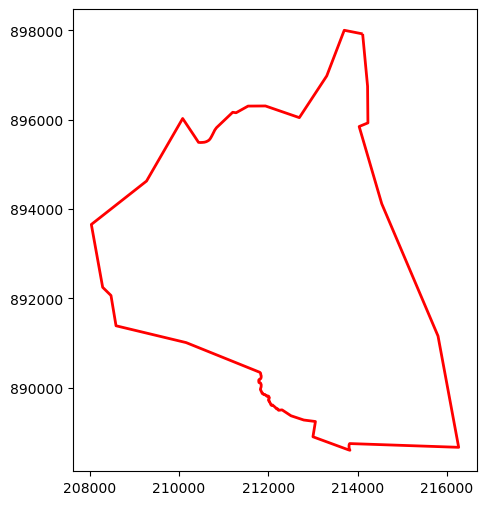

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
p1 = muni_shp.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped_heat, ax=ax)
ax.axis('off')

In [43]:
soils_hsg['COMPNAME'].unique()

component_rule = [
    (soils_hsg['COMPNAME'] == 'Rock outcrop'),
    ((soils_hsg['COMPNAME'] == 'Udorthents') | (soils_hsg['COMPNAME'] == 'Urban land')),
    ((soils_hsg['COMPNAME'] != 'Rock outcrop') &(soils_hsg['COMPNAME'] != 'Udorthents') & (soils_hsg['COMPNAME'] != 'Urban land'))
    ]

choices = [1, 2, -1]
soils_hsg['comp_code'] = np.select(component_rule, choices, default=np.nan).astype(np.float32)



In [30]:
#create a coded field for rock outcrop and hydrologic soil group so it can be converted to a raster


hsg_rule = [
    (soils_hsg['HYDROLGRP'] == 'A'),
    (soils_hsg['HYDROLGRP'] == 'B'),
    (soils_hsg['HYDROLGRP'] == 'C'),
    (soils_hsg['HYDROLGRP'] == 'D'),
    (soils_hsg['HYDROLGRP'] == 'A/D'),
    (soils_hsg['HYDROLGRP'] == 'B/D'),
    (soils_hsg['HYDROLGRP'] == 'C/D'),
    (soils_hsg['HYDROLGRP'] == ' ')
]

choices = [1, 2, 3, 4, 5, 6, 7, -1]

soils_hsg['hsg_code'] = np.select(hsg_rule, choices, default=np.nan).astype(np.float32)
soils_hsg[['HYDROLGRP', 'hsg_code']].head()

,HYDROLGRP,hsg_code
0,B,2.0
1,,-1.0
2,A,1.0
3,B/D,6.0
4,A,1.0


In [44]:
                                  
# Rasterize vector using the shape and transform of the raster
rasterized_landcover = rasterize_geom(lclu, 'covercode', clipped_heat)
rasterized_hsg = rasterize_geom(soils_hsg, 'hsg_code', clipped_heat)
rasterized_landuse = rasterize_geom(lclu, 'usegencode', clipped_heat)
rasterized_soilcomp = rasterize_geom(soils_hsg, 'comp_code', clipped_heat)

(-0.5, 274.5, 314.5, -0.5)

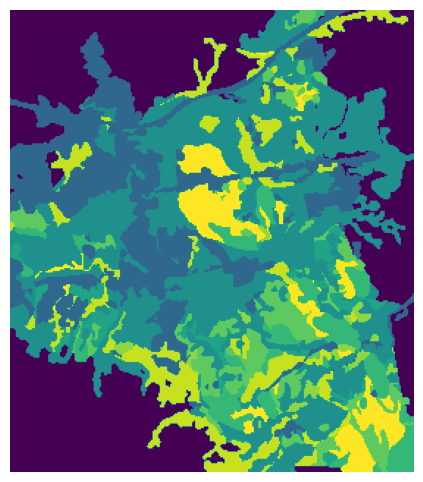

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
p1 = muni_shp.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(rasterized_hsg, ax=ax)
ax.axis('off')

In [51]:
import copy

landcover = rasterized_landcover
hsg = rasterized_hsg
landuse = rasterized_landuse
soilcomp = rasterized_soilcomp

pler = copy.copy(landcover)


# reclassification
pler[np.where(landcover== 21)] = 0

pler[np.where((landcover == 2) 
                   & ((landuse == 10) | (landuse == 12)))] = 2.32 

pler[np.where((landcover == 2) 
                   & ((landuse == 3) | (landuse==4) | (landuse==9) | (landuse==20) | (landuse==30))) ] = 1.78  
    
pler[np.where((landcover == 2) 
                   & (landuse == 55)) ] = 1.95       
 
pler[np.where((landcover == 2) 
                   & (landuse == 6)) ] = 1.52       

pler[np.where((landcover == 2) 
                   & (landuse == 7)) ] = 1.52     
    
pler[np.where((landcover == 2) 
                   & ((landuse == 0) | (landuse ==2) | (landuse==8))) ] = 1.52  
        
pler[np.where((landcover == 2) 
                   & ((landuse==13) | (landuse==11))) ] = 1.96       
   
pler[np.where((landcover != 2) 
                   & ((landcover == 9) | (landcover ==10) | (landcover==12))) ] = 0.13 
        
pler[np.where((landcover != 2) 
                   & (landuse == 6) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==19) |(landcover==20))) ] = 0.13   
       
pler[np.where((landcover != 2) 
                   &  ((landcover == 1) | (landcover==5)))] = 0.45    
                                             
pler[np.where((landcover != 2) 
                   & (landcover == 5) 
                   & (landuse== 7))] = 0.45

pler[np.where((landcover != 2) 
                   & (landcover == 8) 
                   & (landuse== 7))] = 0.45

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 1) | (hsg == 5)))] = 0.03

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 2) | (hsg == 6)))] = 0.12

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & ((hsg == 3) | (hsg == 7)))] = 0.21

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == 4))] = 0.37

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 2))] = 0.21

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 10) | (landuse == 12)))] = 2.32

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 3) | (landuse==4) | (landuse==9) | (landuse==20) | (landuse==30))) ] = 1.78 

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 55)) ] = 1.95  


pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 6)) ] = 1.52    

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & (landuse == 7)) ] = 1.52       

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse == 0) | (landuse ==2) | (landuse==8))) ] = 1.52  

pler[np.where((landcover != 2) 
                   & ((landcover==5) | (landcover==8) | (landcover==13) |(landcover==14)| (landcover==15) | (landcover==16) |(landcover==17)| (landcover==18)| (landcover==19) |(landcover==20)) 
                   & (hsg == -1)
                   & (soilcomp == 1)
                   & ((landuse==13) | (landuse==11))) ] = 1.96 


In [61]:
clipped_heat_muni_path = path + '\\heat_clipped_' + muni + '.tif'
driver = gdal.GetDriverByName('GTiff')
raster = gdal.Open(clipped_heat_muni_path)


# create new reclassified raster
file2 = driver.Create(path + '\\' + muni + '_pler.TIF', raster.RasterXSize , raster.RasterYSize , 1)
file2.GetRasterBand(1).WriteArray(pler)

# spatial ref system
proj = raster.GetProjection()
georef = raster.GetGeoTransform()
file2.SetProjection(proj)
file2.SetGeoTransform(georef)
file2.FlushCache()


In [59]:
file2

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000025497412400> >